In [27]:
!pip install pymser==1.0.18 numpy matplotlib pandas scipy duckdb pyyaml seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.3 kB/s eta 0:00:00a 0:00:02


In [1]:
import pymser
import pandas as pd
from scipy.signal import savgol_filter

import os
import io
import csv
import base64
import numpy
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1.mpl_axes import Axes
import json
import duckdb

import os.path
import math
import re
import datetime

In [3]:
class bmsqlResult:
    def __init__(self, resdir):
        """
        Create a new bmsqlResult instance and load all the data
        in the result directory.
        """
        self.ttypes = [
                'NEW_ORDER',
                'PAYMENT',
                'ORDER_STATUS',
                'STOCK_LEVEL',
                'DELIVERY',
                'DELIVERY_BG',
            ]
        self.resdir = resdir
        self.datadir = os.path.join(resdir, 'data')

        # ----
        # Load the run info into a dict
        # ----
        fname = os.path.join(self.datadir, 'runInfo.csv')
        with open(fname, newline = '') as fd:
            rdr = csv.DictReader(fd)
            self.runinfo = next(rdr)

        self.faultinfo = {}
        fault_fname = os.path.join(self.datadir, 'faultInfo.csv')
        with open(fault_fname, newline = '') as fd:
            rdr = csv.DictReader(fd)
            # if there is no fault, the faultinfo will be empty even
            for row in rdr:
                # only one fault is allowed currently
                self.faultinfo = dict(row)
                break  

        self.trace_fname = os.path.join(self.datadir, 'trace.csv')
        with open(self.trace_fname, newline='') as fd:
            rdr = csv.DictReader(fd)
            self.txn_trace = [row for row in rdr]

        txn_fname = os.path.join(self.datadir, 'txnlog.csv')

        self.rto = self.rto(self.trace_fname)
        self.rpo = self.rpo(self.trace_fname, txn_fname)

        # write rto and rpo result into metrics.csv
        metrics_fname = os.path.join(self.datadir, 'metrics.csv')
        with open(metrics_fname, 'w', newline='') as fd:
            wrt = csv.writer(fd)
            wrt.writerow(['rto', 'rpo'])
            wrt.writerow([self.rto, self.rpo])
        
        # ----
        # Load the other CSV files into dicts of arrays.
        #
        #   result_ttype    a dict of result_data slices by transaction type
        #
        #   summary_ttype   a dict of transaction summary info per type
        #
        #   hist_ttype      a dict of hist_data slices by transaction type
        #
        #   hist_bins       the number of bins in the histogram
        #
        #   hist_cutoff     the edge of the last bin in the histogram
        #
        # Loading of the summary will fail if the benchmark run is
        # still in progress or has been aborted. We then return with
        # an incoplete result, which still allows drawing graphs.
        # ----
        self.result_ttype = self._load_ttype_csv_multiple('result.csv')
        try:
            self.summary_ttype = self._load_ttype_csv_single('summary.csv')
        except StopIteration:
            return
        self.hist_ttype = self._load_ttype_csv_multiple('histogram.csv')
        self.hist_bins = len(self.hist_ttype['NEW_ORDER'])
        self.hist_cutoff = self.hist_ttype['NEW_ORDER'][-1][0]
        self.hist_statsdiv = math.log(self.hist_cutoff * 1000.0) / self.hist_bins

        # ----
        # The total number of "measured" transactions is the sum summary
        # counts but without the delivery background transactions.
        # ----
        self.total_trans = (sum([self.summary_ttype[tt][0]
                                for tt in self.ttypes])
                                - self.summary_ttype['DELIVERY_BG'][0])

        # ----
        # If an OS metric collector was running, load its data.
        # ----
        os_metric_fname = os.path.join(self.datadir, 'os-metric.json')
        if os.path.exists(os_metric_fname):
            with open(os_metric_fname) as fd:
                self.os_metric = json.loads(fd.read())
        else:
            self.os_metric = {}

        # ----
        # Load the run.properties but remove the password
        # ----
        prop_fname = os.path.join(resdir, 'run.properties')
        with open(prop_fname, 'r') as fd:
            props = fd.read()
        # parse the properties file, and find scenario name, if no scenario name, set it to uncertain
        self.scenario_name = re.search(r'scenario\s*=\s*(.*)', props, re.M).group(1) if re.search(r'scenario\s*=\s*(.*)', props, re.M) else "uncertain"
        self.properties = re.sub(r'(password\s*=\s*).*$', r'\1********',
                                 props, flags = re.M)

    def tpm_c(self):
        num_new_order = self.summary_ttype['NEW_ORDER'][0]
        return num_new_order / int(self.runinfo['runMins'])

    def tpm_total(self):
        return self.total_trans / int(self.runinfo['runMins'])

    def percentile(self, tt, nth):
        """
        Returns the nth percentile response time of transaction type tt
        """
        nth_have = 0
        nth_need = int(self.summary_ttype[tt][0] * nth)
        b = 0
        for b in range(0, self.hist_bins):
            if nth_have >= nth_need:
                break
            nth_have += int(self.hist_ttype[tt][b][1])
        return math.exp(float(b) * self.hist_statsdiv) / 1000.0

    def num_trans(self, tt):
        """
        Returns the total number of transaction for the given type
        during the measurement cycle
        """
        return int(self.summary_ttype[tt][0])

    def trans_mix(self, tt):
        """
        Returns the percentage of the transaction type overall
        """
        return self.summary_ttype[tt][1]

    def avg_latency(self, tt):
        """
        Returns the average latency for the given transaction type
        during the measurement cycle
        """
        return self.summary_ttype[tt][2]

    def max_latency(self, tt):
        """
        Returns the maximum latency for the given transaction type
        during the measurement cycle
        """
        return self.summary_ttype[tt][3]

    def num_rollbacks(self, tt):
        """
        Returns the number of rollbacks that happened for the transaction
        type. This is only useful for NEW_ORDER.
        """
        return int(self.summary_ttype[tt][4])

    def num_errors(self, tt):
        """
        Returns the number of errors encountered for the transaction type
        during the measurement cycle
        """
        return int(self.summary_ttype[tt][5])

    def _load_ttype_csv_single(self, fname, skip_header = True):
        """
        Read a CSV file that has the transaction type as the first element.
        We expect a single row per transaction type.
        """
        ttdict = {}
        path = os.path.join(self.datadir, fname)
        with open(path, newline = '') as fd:
            rdr = csv.reader(fd)
            if skip_header:
                _ = next(rdr)
            for row in rdr:
                tt = row[0]
                ttdict[tt] = [float(d) for d in row[1:]]

        return ttdict

    def _load_ttype_csv_multiple(self, fname, skip_header = True):
        """
        Read a CSV file that has the transaction type as the first element.
        Return a list of tuples as well as a dict that has lists of tuples
        separated by transaction type.
        """
        ttdict = {}
        path = os.path.join(self.datadir, fname)
        with open(path, newline = '') as fd:
            rdr = csv.reader(fd)
            if skip_header:
                _ = next(rdr)
            data = [[row[0], [float(d) for d in row[1:]]] for row in rdr]

            for ttype in self.ttypes:
                tuples = filter(lambda x : x[0] == ttype, data)
                ttdict[ttype] = [tup[1] for tup in tuples]

        return ttdict

    def rto(self, trace_file):
        """
        Returns the recovery time objective in seconds.
        """
        if self.faultinfo == {}:
            print("No fault found")
            return 

        con = duckdb.connect()

        # create a table from the trace file
		# CREATE TABLE transactions AS SELECT * FROM read_csv_auto('service_data/result_000137/data/trace.csv');
        con.execute("""
            CREATE TABLE transactions AS SELECT * FROM read_csv_auto('""" + trace_file + """');""")

        # find the fault start time and recovery end time
        # step1: find all transactions whose result is error or rollback and record end time as possible fault start time, the txn_id >> 32 is the thread id
		# CREATE TEMP TABLE error_transactions AS SELECT txn_id >> 32 AS thread_id ,transactions.start AS start_time, transactions.end AS end_time FROM transactions WHERE error = 1;
		# step2: find all sucessful transactions and record its thread_id and start time and end time
		# CREATE TEMP TABLE successful_transactions AS SELECT txn_id >> 32 AS thread_id, transactions.start AS start_time, transactions.end AS end_time FROM transactions WHERE error = 0 AND rollback = 0;
        # step3: find the first transaction after the fault start time that is not error or rollback and record end time as possible recovery end time for each thread in error_transactions, the fault start time and recovery end time pair is  rto interval
		# CREATE TEMP TABLE recovery_interval AS SELECT t.thread_id, t.end_time as fault_start, st.end_time as recovery_end FROM error_transactions t ASOF JOIN successful_transactions st ON t.thread_id = st.thread_id AND t.end_time < st.end_time;
        rto_query = """
            WITH successful_transactions AS (
				SELECT txn_id >> 32 AS thread_id, transactions.start AS start_time, transactions.end AS end_time
				FROM transactions
				WHERE error = 0 AND rollback = 0
            ),
			error_transactions AS (
				SELECT txn_id >> 32 AS thread_id, transactions.start AS start_time, transactions.end AS end_time
				FROM transactions
				WHERE error = 1 OR rollback = 1
            )
			SELECT t.thread_id, t.end_time as fault_start, st.end_time as recovery_end
			FROM error_transactions t
			ASOF JOIN successful_transactions st
			ON t.thread_id = st.thread_id AND t.end_time < st.end_time;
        """

        # get all RTO intervals and group by thread_id, for overlapped intervals of the same thread_id, merge them
        intervals = con.execute(rto_query).fetchall()

		# get threads number
        threads_num = con.execute("SELECT COUNT(DISTINCT (txn_id >> 32)) FROM transactions;").fetchone()[0]
        con.close()

        merged_intervals = {}
        for interval in intervals:
            thread_id, fault_start, recovery_end = interval
            if thread_id not in merged_intervals:
                merged_intervals[thread_id] = [(fault_start, recovery_end)]
            else:
                # check if the current interval overlaps with any of the existing intervals, if yes, merge current interval into the existing interval
                merged = False
                for i, (existing_start, existing_end) in enumerate(merged_intervals[thread_id]):
                    if fault_start <= existing_end and recovery_end >= existing_start:
                        merged_intervals[thread_id][i] = (min(fault_start, existing_start), max(recovery_end, existing_end))
                        merged = True
                        break
                if merged == False:
                    merged_intervals[thread_id].append((fault_start, recovery_end))

        # compute sum of interval duration for each thread_id, and compute the average interrupt time according thread_id
        interrupt_time = {}
        for thread_id, intervals in merged_intervals.items():
            interrupt_time[thread_id] = sum([interval[1] - interval[0] for interval in intervals])

        avg_interrupt_time = sum(interrupt_time.values()) / int(threads_num)

        # print all interrupt intervals
        for thread_id, intervals in merged_intervals.items():
            for interval in intervals:
                print(f"Thread {thread_id}: interrupt start time: {datetime.datetime.fromtimestamp(interval[0] / 1000)}, recovery end time: {datetime.datetime.fromtimestamp(interval[1] / 1000)}")


        print(f"Average interrupt time: {avg_interrupt_time} ms")
        return avg_interrupt_time

    def rpo(self, trace_file, txn_file):
        """
        Returns the recovery point objective in milliseconds.
        """
        if self.faultinfo == {}:
            print("No fault found")
            return
        
        # get all txn from trace file, and compare with txn file
        # find all loss txn_id who are in trace file but are not in txn file
        # the rpo result is the merge interval of all loss txn_id interval
        # for example, if the loss txn_id interval(start, end) is [1, 3], [2, 6], [5, 9], [15, 17], then the rpo result is len([1, 9]) + len([15, 17]) = 8 + 2 = 10
        
        persisted_txn_ids = set()
        with open(txn_file, newline='') as fd:
            rdr = csv.DictReader(fd)
            for row in rdr:
                persisted_txn_ids.add(row['txn_id'])
        
        loss_txn_intervals = []
        with open(trace_file, newline='') as fd:
            rdr = csv.DictReader(fd)
            for row in rdr:
                if int(row['error'])==1 or int(row['rollback'])==1:
                    continue
                if row['txn_id'] not in persisted_txn_ids:
                    loss_txn_intervals.append((int(row['start']), int(row['end'])))
        
        loss_txn_intervals.sort()
        merged_intervals = []
        for interval in loss_txn_intervals:
            if not merged_intervals or merged_intervals[-1][1] < interval[0]:
                merged_intervals.append(interval)
            else:
                merged_intervals[-1] = (merged_intervals[-1][0], max(merged_intervals[-1][1], interval[1]))
        
        rpo = sum([interval[1] - interval[0] for interval in merged_intervals])

        print(f"RPO: {rpo} ms")
        return rpo


In [16]:
class bmsqlPlot:
    FIGSIZE = [10, 2.5]

    def __init__(self, result):
        self.result = result
        self.data = {}

    def tpmc_svg_show(self, b64encode = True):
		# 设置全局字体为 Noto Mono
        plt.rcParams['font.family'] = 'Noto Serif CJK JP'
        plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        fig = plt.figure(figsize = self.FIGSIZE)

        h = [Size.Fixed(1.2), Size.Scaled(1.), Size.Fixed(.2)]
        v = [Size.Fixed(0.7), Size.Scaled(1.), Size.Fixed(.5)]

        divider = Divider(fig, (0.0, 0.0, 1., 1.), h, v, aspect=False)
        plot = Axes(fig, divider.get_position())
        plot.set_axes_locator(divider.new_locator(nx=1, ny=1))

        fig.add_axes(plot)

        result = self.result
        runinfo = result.runinfo

        warmupseconds = int(runinfo['rampupMins'])*60

        # ----
        # The X limits are -rampupMins, runMins
        # ----
        plot.set_xlim(-int(runinfo['rampupMins'])*60, int(runinfo['runMins'])*60)
        plot.axvspan(-int(runinfo['rampupMins'])*60, 0,
                    facecolor = '0.2', alpha = 0.1)

        # ----
        # offset the timestamps by -rampupMins so that the graph
        # starts with negative minutes elapsed and switches to
        # positive when the measurement begins.
        # ----
        offset = (int(runinfo['rampupMins'])) * 60.0

        total_seconds = int(runinfo['rampupMins'])*60 + int(runinfo['runMins'])*60
        startTS = (int(runinfo['startTS']))
        txn_stat = [0 for i in range(total_seconds)]
        x = range(-int(runinfo['rampupMins'])*60, int(runinfo['runMins'])*60, 1)
        for row in result.txn_trace:
            end = (int(row['end']) - startTS)//1000 
            if end >=0 and end < total_seconds:
                txn_stat[end]+=1

        # print('transactions per second: {}'.format(txn_stat))
        # ceil fault_time
        fault_time = math.ceil((int(result.faultinfo['start']) - startTS)/1000)
        # fault_time = (int(result.faultinfo['start']) - startTS)/1000
        # ----
        # Use pymser to find the steady state
        # ----

        sd = txn_stat[fault_time:]
        sd = sd[:]
        sd = savgol_filter(sd, 10, 2)
        stready_result = pymser.equilibrate(sd, batch_size=1, LLM=True, ADF_test=False, uncertainty='uSD', print_results=True)
        mse = stready_result['MSE']
        mse = mse[:math.floor(0.8*len(mse))]
        # mse = savgol_filter(mse, 10, 1)
        print("mse: {}", mse)

        # find min mse
        minn = 0
        # for i in range(1, len(mse)):
        #     if mse[i] < mse[minn]:
        #         minn = i

        k = 15
        # 找到第一个是比前后k个都小的点
        for i in range(0, len(mse)):
            is_local_min = True
            for j in range(max(0, i-k), min(len(mse), i+k+1)):
                if mse[j] < mse[i]:
                    is_local_min = False
                    break
            if is_local_min:
                minn = i
                break
            
        print("recovery end {}",minn)
        # print txns during recovery state
        print("txns during recovery state: {}", txn_stat[fault_time-1:fault_time+minn])
            
        # plot.axvspan(fault_time- warmupseconds, fault_time - warmupseconds + max(minn, 1), facecolor = 'r', alpha = 0.1)

        # # find the first point where throughput is high than avarage throughput of last minute 
        # avarage_throughput = sum(txn_stat[-60:])/60
        # for i in range(fault_time, len(txn_stat)):
        #     if txn_stat[i] > avarage_throughput*1.22:
        #         break
		# # plot the recovery state to red
        # plt.axvspan(fault_time- warmupseconds, fault_time - warmupseconds + max(i-fault_time, 1), facecolor = 'r', alpha = 0.6)
        # print("recovery end {}",i - fault_time)

		# plot the steady state to red
        plot.axvspan(fault_time- warmupseconds, fault_time - warmupseconds + max(stready_result['t0'], 1), facecolor = 'r', alpha = 0.2)
		
	    # plot mse result line in green
        # plot.plot(range(fault_time- warmupseconds, fault_time - warmupseconds + len(mse)), mse, 'g')

        # ----
        # Plot the NOPM and add all the decorations
        # ----
        plot.plot(x, txn_stat, 'b')
        # plot.set_title("NEW_ORDER Transactions per seonds")
        plot.set_xlabel("时间（秒）")
        plot.set_ylabel("QPS（完成事务数量/秒）")
        plot.grid()

        smoothed = savgol_filter(txn_stat, 5, 1)
        # plt.plot(x, smoothed, 'r', label='Smoothed Data')
        plot.legend(loc='lower right', prop={'size': 8}, bbox_to_anchor=(1.04, 0.0))

        # plt.show()
        fig = plot.get_figure()
        fig.show()


Thread 0: interrupt start time: 2025-01-24 21:46:11.363000, recovery end time: 2025-01-24 21:46:11.706000
Thread 5: interrupt start time: 2025-01-24 21:46:11.366000, recovery end time: 2025-01-24 21:46:11.716000
Thread 9: interrupt start time: 2025-01-24 21:45:09.987000, recovery end time: 2025-01-24 21:45:10.312000
Thread 14: interrupt start time: 2025-01-24 21:46:10.905000, recovery end time: 2025-01-24 21:46:11.515000
Thread 8: interrupt start time: 2025-01-24 21:46:10.908000, recovery end time: 2025-01-24 21:46:11.518000
Thread 13: interrupt start time: 2025-01-24 21:46:11.364000, recovery end time: 2025-01-24 21:46:11.706000
Thread 19: interrupt start time: 2025-01-24 21:46:11.375000, recovery end time: 2025-01-24 21:46:11.718000
Thread 21: interrupt start time: 2025-01-24 21:46:10.905000, recovery end time: 2025-01-24 21:46:11.800000
Thread 25: interrupt start time: 2025-01-24 21:46:11.367000, recovery end time: 2025-01-24 21:46:11.715000
Thread 23: interrupt start time: 2025-01-

/tmp/ipykernel_849770/808875267.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plot.legend(loc='lower right', prop={'size': 8}, bbox_to_anchor=(1.04, 0.0))
/tmp/ipykernel_849770/808875267.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


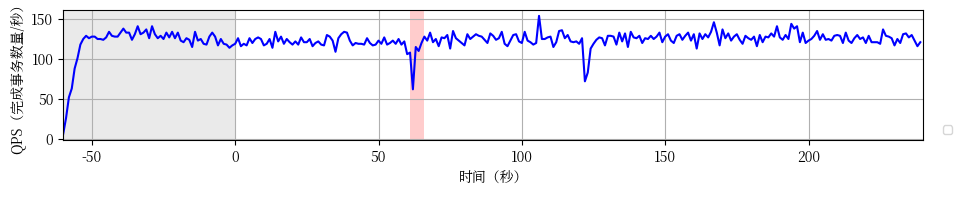

In [18]:
result = bmsqlResult('target/run/service_data/result_000623')
plot = bmsqlPlot(result)
plot.tpmc_svg_show()

In [ ]:
import yaml

# YAML 文件内容
yaml_content = """
apiVersion: chaos-mesh.org/v1alpha1
kind: Workflow
metadata: {name: net-loss-then-failure-example}
spec:
  entry: net-loss-then-failure
  templates:
  - name: net-loss-then-failure
    templateType: Serial
    deadline: 600s
    children: [workflow-loss-chaos, workflow-failure-chaos]
  - name: workflow-loss-chaos
    templateType: NetworkChaos
    deadline: 480s
    networkChaos:
      mode: all
      action: loss
      selector:
        namespaces: [oceanbase2]
        labelSelectors: {ref-obzone: obcluster-1-zone3}
      loss: {loss: '100'}
  - name: workflow-failure-chaos
    templateType: PodChaos
    deadline: 2m
    podChaos:
      action: pod-failure
      mode: all
      selector:
        namespaces: [oceanbase2]
        labelSelectors: {ref-obzone: obcluster-1-zone1}
  - name: parallel-example
    templateType: Parallel
    deadline: 300s
    children: [workflow-loss-chaos, workflow-failure-chaos]
"""

# 解析 YAML 内容
data = yaml.safe_load(yaml_content)


# 从 entry 开始递归解析
entry_template = data['spec']['entry']
templates = data['spec']['templates']
fault_periods = parse_template(entry_template, templates)

# 打印结果
print("故障时间段:")
for period in fault_periods:
    print(
        f"- 模板名称: {period['name']}, "
        f"类型: {period['templateType']}, "
        f"开始时间: {period['start_time']} 秒, "
        f"结束时间: {period['end_time']} 秒, "
        f"持续时间: {period['duration_seconds']} 秒"
    )

# 计算总故障时间
total_duration = max(period['end_time'] for period in fault_periods) - fault_periods[0]['start_time']
print(f"总故障时间: {total_duration} 秒")

故障时间段:
- 模板名称: workflow-loss-chaos, 类型: NetworkChaos, 开始时间: 0 秒, 结束时间: 480 秒, 持续时间: 480 秒
- 模板名称: workflow-failure-chaos, 类型: PodChaos, 开始时间: 480 秒, 结束时间: 600 秒, 持续时间: 120 秒
总故障时间: 600 秒


/tmp/ipykernel_1279288/4279735045.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values(), labels=data.keys())


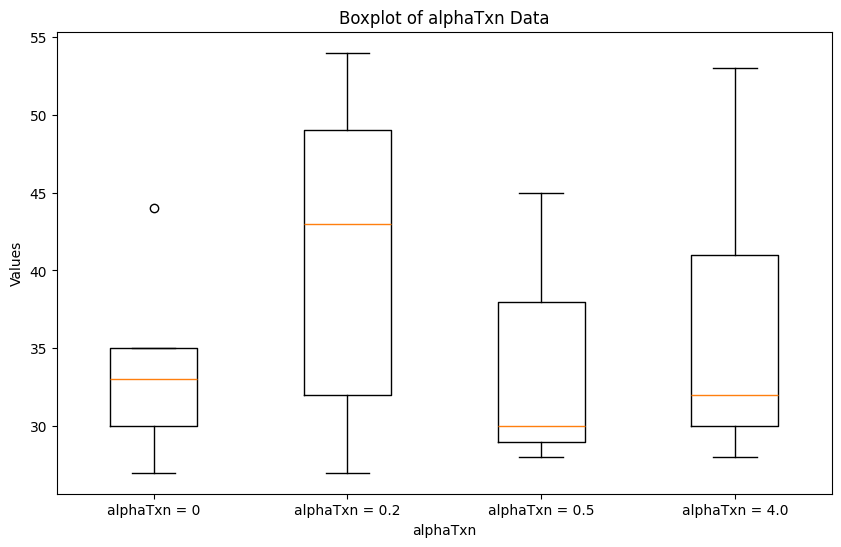

In [ ]:
# 数据
data = {
    'alphaTxn = 0': [27, 33, 44, 35, 30],
    'alphaTxn = 0.2': [49, 27, 32, 43, 54],
    'alphaTxn = 0.5': [30, 45, 29, 38, 28],
    'alphaTxn = 4.0': [53, 28, 32, 41, 30]
}

# 绘制箱型图
plt.figure(figsize=(10, 6))
plt.boxplot(data.values(), labels=data.keys())
plt.title('Boxplot of alphaTxn Data')
plt.ylabel('Values')
plt.xlabel('alphaTxn')
plt.show()

In [23]:
from matplotlib.font_manager import fontManager
fonts = [f.name for f in fontManager.ttflist if 'CJK' in f.name]
print(fonts)

['Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Serif CJK JP']


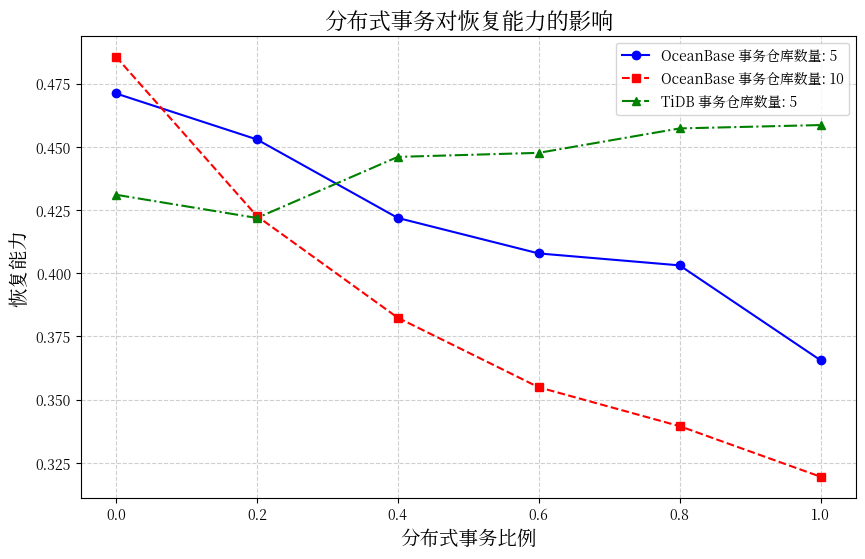

In [24]:
# 设置全局字体为 Noto Mono
plt.rcParams['font.family'] = 'Noto Serif CJK JP'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 提取的数据
distributedRatios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# OceanBase 数据
# distributedNodes: 5 的数据
ob_average_recovery_factors_5 = [
    0.47107169313366476, 0.45288947630221427, 0.42183031428382073,
    0.40779771408631194, 0.40307549317315855, 0.3655470420398436
]

# distributedNodes: 10 的数据
ob_average_recovery_factors_10 = [
    0.4856002791491027, 0.4225740916443299, 0.3823621264358044,
    0.3548595276335165, 0.3394855413338132, 0.31948098629522986
]

# TiDB 数据
tidb_average_recovery_factors_5 = [
    0.43100270336692065, 0.42182007551100115, 0.44598194464999263,
    0.44758309175487093, 0.4572433313320181, 0.4585717645214392
]

# 创建折线图
plt.figure(figsize=(10, 6))  # 设置图形大小

# 绘制 OceanBase distributedNodes: 5 的曲线
plt.plot(distributedRatios, ob_average_recovery_factors_5, marker='o', linestyle='-', color='b', label='OceanBase 事务仓库数量: 5')

# 绘制 OceanBase distributedNodes: 10 的曲线
plt.plot(distributedRatios, ob_average_recovery_factors_10, marker='s', linestyle='--', color='r', label='OceanBase 事务仓库数量: 10')

# 绘制 TiDB distributedNodes: 5 的曲线
plt.plot(distributedRatios, tidb_average_recovery_factors_5, marker='^', linestyle='-.', color='g', label='TiDB 事务仓库数量: 5')

# 添加标题和标签
plt.title('分布式事务对恢复能力的影响', fontsize=16)
plt.xlabel('分布式事务比例', fontsize=14)
plt.ylabel('恢复能力', fontsize=14)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.6)

# 设置x轴刻度
plt.xticks(distributedRatios)

# 添加图例
plt.legend()

# 显示图形
plt.show()

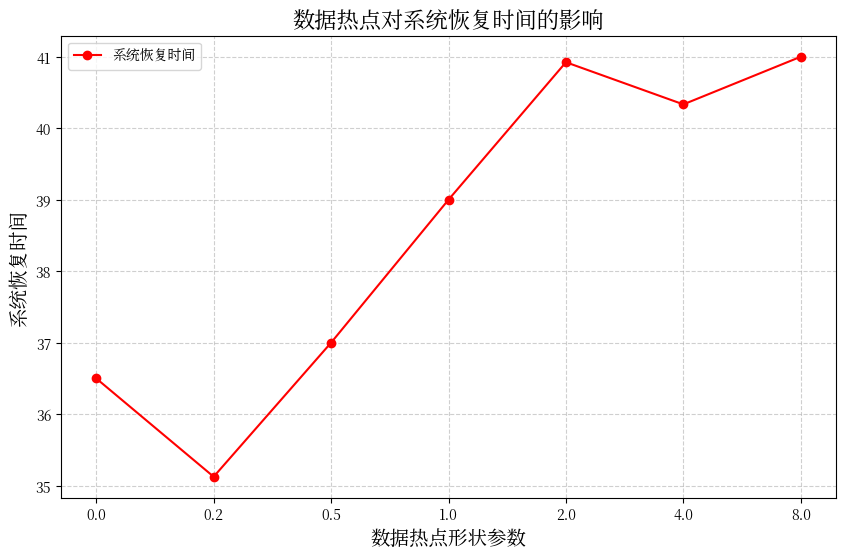

In [25]:
# 提取的数据
alphaTxn = [0.0, 0.2, 0.5, 1.0, 2.0, 4.0, 8.0]
average_recovery_ends = [36.5, 35.125, 37.0, 39.0, 40.92307692307692, 40.333333333333336, 41.0]

# 创建等间隔的横坐标索引
x_indices = range(len(alphaTxn))  # [0, 1, 2, 3, 4, 5, 6]

# 创建折线图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(x_indices, average_recovery_ends, marker='o', linestyle='-', color='r', label='系统恢复时间')

# 添加标题和标签
plt.title('数据热点对系统恢复时间的影响', fontsize=16)
plt.xlabel('数据热点形状参数', fontsize=14)
plt.ylabel('系统恢复时间', fontsize=14)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.6)

# 设置横坐标为等间隔索引，并映射为alphaTxn的值
plt.xticks(x_indices, alphaTxn)  # 将索引映射为alphaTxn的值

# 添加图例
plt.legend()

# 显示图形
plt.show()

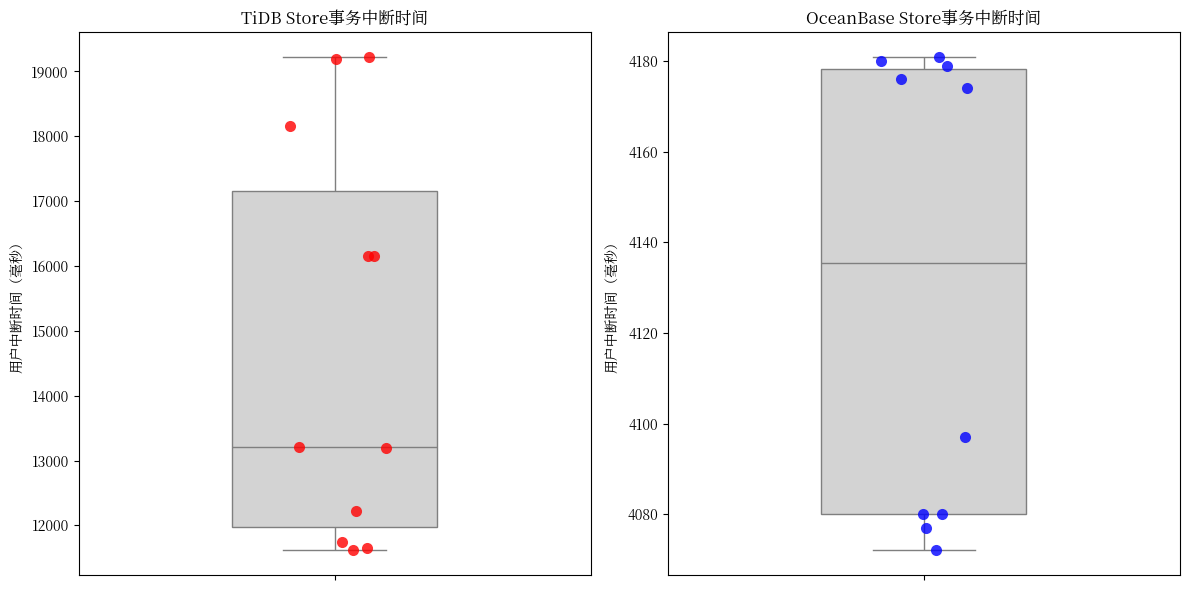

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据
tidb_store_interrupts = [16150, 16151, 19226, 19181, 11751, 18160, 13192, 11646, 11615, 13215, 12216] #avg 6.4中断用户 6 node 32 thread
ob_store_interrupts = [4181, 4077, 4176, 4097, 4180, 4080, 4072, 4080, 4174, 4179] #avg 5.6中断用户 6node 3zone

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 绘制 TiDB Store Interrupts 的箱型图和数据点
sns.boxplot(data=tidb_store_interrupts, ax=ax1, color='lightgray', width=0.4)  # 降低箱型图颜色饱和度
sns.stripplot(data=tidb_store_interrupts, ax=ax1, color='red', size=8, jitter=True, alpha=0.8)  # 突出散点
ax1.set_title('TiDB Store事务中断时间')
ax1.set_ylabel('用户中断时间（毫秒）')

# 绘制 OB Store Interrupts 的箱型图和数据点
sns.boxplot(data=ob_store_interrupts, ax=ax2, color='lightgray', width=0.4)  # 降低箱型图颜色饱和度
sns.stripplot(data=ob_store_interrupts, ax=ax2, color='blue', size=8, jitter=True, alpha=0.8)  # 突出散点
ax2.set_title('OceanBase Store事务中断时间')
ax2.set_ylabel('用户中断时间（毫秒）')

# 调整布局
plt.tight_layout()
plt.show()